In [18]:
import pandas as pd
import numpy as np
import time
import calendar

Model Building
========
The goal is to build a model for the livability score that is able to be displayed on a map.

In [32]:
# download Josh's cleaned data set: https://s3.us-east-2.amazonaws.com/chipy6242/dataset_clean.csv
# if you don't have the file locally, you can just pass the URL directly
df = pd.read_csv('dataset_clean.csv', parse_dates=['datetime'])
df.head()

,zipcode,subsystem,lat,long,sensor,parameter,datetime,avg
0,60601,chemsense,41.884607,-87.624577,no2,concentration,2018-05-10 19:00:00,0.006243
1,60612,chemsense,41.871480,-87.676440,at0,temperature,2018-05-01 12:00:00,27.369161
2,60610,chemsense,41.903632,-87.648093,so2,concentration,2018-05-05 03:00:00,0.197254
3,60606,lightsense,41.883260,-87.633870,tmp421,temperature,2018-05-04 02:00:00,39.129429
4,60639,chemsense,41.923996,-87.761072,at3,temperature,2018-05-09 14:00:00,27.192733


## Available Observations

In [3]:
df[['subsystem','sensor','parameter']].dropna().drop_duplicates()

,subsystem,sensor,parameter
0,chemsense,no2,concentration
1,chemsense,at0,temperature
2,chemsense,so2,concentration
3,lightsense,tmp421,temperature
4,chemsense,at3,temperature
5,metsense,mma8452q,acceleration_z
6,plantower,pms7003,point_5um_particle
7,alphasense,opc_n2,pm2_5
8,metsense,hih4030,humidity
9,lightsense,mlx75305,intensity


In [50]:
# Create the independent variables
# X = dfData[(dfData.subsystem=='ELPC') & (dfData.sensor == 'mobile') & (dfData.parameter == 'pm2_5')]
X = df[(df.parameter == 'pm2_5')] # Mix both ELPC and AoT data for pm2.5
X = X[['datetime','lat','long']]
X['hod'] = X['datetime'].apply(lambda x: x.hour)
X['dow'] = X['datetime'].apply(lambda x: x.dayofweek)
X = X[['hod','lat','long']]

In [23]:
# @Ignore
# @Deprecated
# NOTE: This could possibly be the slowest way to do this, but it's the first thing I thought of
# X[:, 0] = [calendar.timegm(time.strptime(X[:, 0][i], '%Y-%m-%d %H:%M:%S')) for i in range(len(X[:, 0]))]
# TODO: Need to add features for hour of day, day of week
# I would suggest adding more for month of year, day of year, etc... but we are only looking at the summer

In [8]:
# Create the predicted variable
# y = dfData[(dfData.subsystem=='alphasense') & (dfData.sensor == 'opc_n2') & (dfData.parameter == 'pm2_5')]
y = df[(df.parameter == 'pm2_5')]
y = y['avg']

## Build the predictive models

In [12]:
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

In [51]:
# Split the data into a Training and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True)
# TODO: Standardize the parameters, use Pipeline?

In [28]:
models = [ # list of tuples of (ModelClass, grid-searchable hyperparameters dictionary)
    (KNeighborsRegressor, { 'n_neighbors': [3, 5, 10], 'weights': ['distance'] }),
    (RandomForestRegressor, { 'n_estimators': [100, 1000], 'max_depth': [None] }),
    # (LinearRegression, {}),
    #(SVC, { 'C': [1.0] })
]

In [183]:
# Ideas to explore:
# - KNN
# - Triangulated irregular network / Delaunay triangulation
# - Natural neighbor
# - Inverse distance weighting (IDW)
# - Radial Basis Functions (RBF)
# - Thin plate splines
# - Kriging
# - Artificial Neural Networks

for (model, params) in models:
    # Grid Search for the best hyper parameters
    print('=== {} ==='.format(model.__name__))
    gridSearch = GridSearchCV(model(), param_grid=params, refit=True)
    gridSearch.fit(X_train, y_train)
    print('  Best Params:', gridSearch.best_params_)
    
    # Check its accuracy by looking at the Root Mean Square Error of the KNN on the Test dataset
    y_pred = gridSearch.predict(X_test)
    dfTest = pd.DataFrame([y_pred, y_test]).transpose()
    dfTest.columns=('p','y')
    rmse = ((dfTest.p - dfTest.y) ** 2).mean() ** .5
    print('  RMSE = {} μg/m^3'.format(rmse))
    score = gridSearch.score(X_test, y_test)
    print('  Coefficient of determination R^2 of the prediction = {}'.format(score))

=== KNeighborsRegressor ===
  Best Params: {'n_neighbors': 10, 'weights': 'distance'}
  RMSE = 6.115680026962663 μg/m^3
  Coefficient of determination R^2 of the prediction = 0.4854078780231029
=== RandomForestRegressor ===
  Best Params: {'max_depth': None, 'n_estimators': 1000}
  RMSE = 6.177891819257352 μg/m^3
  Coefficient of determination R^2 of the prediction = 0.4748852451067406
=== LinearRegression ===
  Best Params: {}
  RMSE = 8.45206093775375 μg/m^3
  Coefficient of determination R^2 of the prediction = 0.017123701699845895


In [174]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
from cartopy import config
import cartopy.crs as ccrs
%matplotlib notebook

## Now we pick one of the above models and build it out
Let's use all the data since we are no longer validating.

In [53]:
model = KNeighborsRegressor(n_neighbors=10, weights = 'distance')
model.fit(X, y)

KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
          metric_params=None, n_jobs=1, n_neighbors=10, p=2,
          weights='distance')

## The Grid
We need a grid of coordinates over which we will do our interpolation. For now, let's use the min/max of our given sensor inputs, but in theory this should be the entire area we want to map.

Also, for this demo, we'll only use a single time of day - using noon here, but for production we'll need to do this for all hours of the day.

In [56]:
max_lat = X['lat'].min()
min_lat = X['lat'].max()
max_lon = X['long'].min()
min_lon = X['long'].max()
print('Latitude Range: {} to {}'.format(min_lat, max_lat))
print('Longitude Range: {} to {}'.format(min_lon, max_lon))

Latitude Range: 41.983275 to 41.7052
Longitude Range: -87.52757 to -87.78208166700001


In [59]:
hod = 12 # NOON
resolution_lon = 100
resolution_lat = 100

resolution = resolution_lon * resolution_lat
grid_lon = np.linspace(min_lon, max_lon, resolution_lon)
grid_lat = np.linspace(min_lat, max_lat, resolution_lat)

In [156]:
# Build an array with 2 columns that consists of every combination of the lat/lon's in the interpolation grid
grid_lon_lat = np.reshape(np.asarray(np.meshgrid(grid_lon, grid_lat)), (2, resolution))

In [162]:
data = np.zeros((resolution, 3))
data[:, 0] = hod
data[:, 2] = grid_lon_lat[0,:]
data[:, 1] = grid_lon_lat[1,:]

In [163]:
X_grid = pd.DataFrame(data=data, columns=['hod', 'lat', 'long'])

<IPython.core.display.Javascript object>


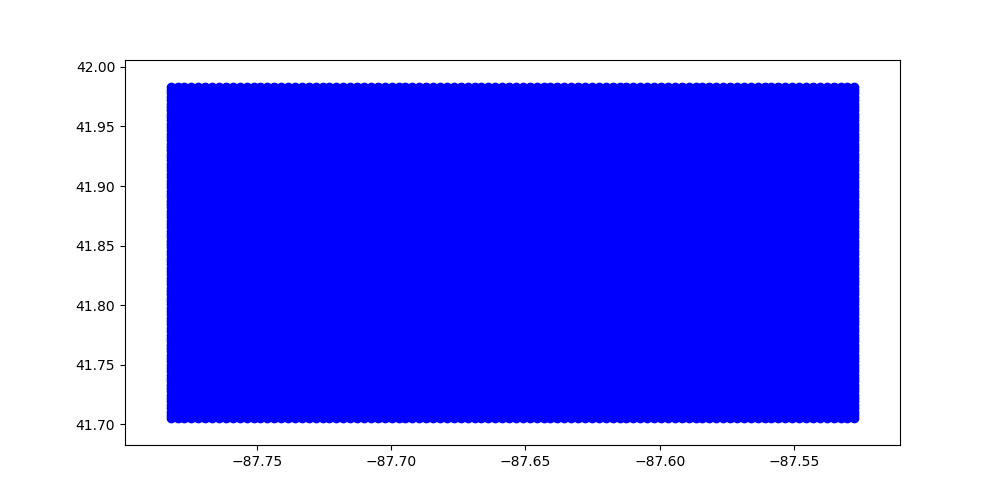

In [166]:
# This is just a test to see that we get a giant plane that we interpolate over.
fig = plt.figure(figsize=(10,5))
ax = fig.add_subplot(111)
ax.scatter(data[:,2], data[:,1], color='b')
plt.show()

## Interpolate
Now we have enough to create an interpolation across the grid so lets try that for a single time.

In [167]:
z = model.predict(X_grid)

In [176]:
avgs = np.reshape(z, (resolution_lon, resolution_lat))

## Now can we map it?

<IPython.core.display.Javascript object>


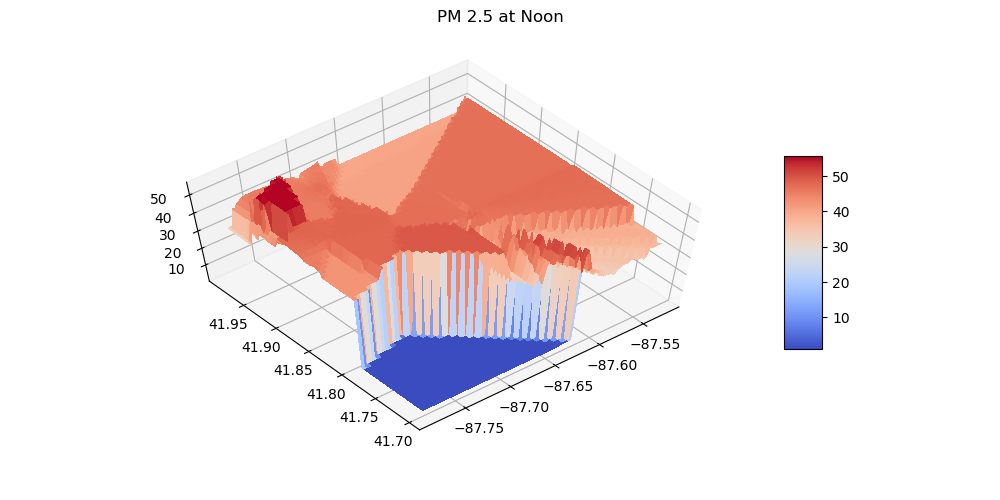

In [182]:
# Plot in 3-d
fig = plt.figure(figsize=(10,5))
fig.suptitle('PM 2.5 at Noon')
ax = fig.gca(projection='3d')
lons = np.reshape(grid_lon_lat[0], (100, 100))
lats = np.reshape(grid_lon_lat[1], (100, 100))
surf = ax.plot_surface(lons, lats, avgs, 
                       cmap=cm.coolwarm, linewidth=0, antialiased=False)
fig.colorbar(surf, shrink=0.5, aspect=5)

plt.show()

### Ok, now how do we verify this is correct?

The low values look like they could be water, the high vlaues look like they could be Midway? Obviously we have some dead-zones where there isn't a lot of data.

In [ ]:
# Plot on map - WIP
# plt.figure(figsize=(10,10))
# ax = plt.axes(projection=ccrs.PlateCarree())
# ax.set_extent([min_lon, max_lon, min_lat, max_lat], crs=ccrs.PlateCarree())
# plt.contourf(grid_lon, grid_lat, avgs, 60, transform=ccrs.PlateCarree())
# plt.pcolormesh(grid_lon, grid_lat, avgs)
# ax.coastlines()

In [184]:
# My Notes

# TODO: 
#  1) Use model to predict grid of results
#     np.linspace()
#  2) Use model to build "score"
#  3) Correlate score to AQI
#  4) How to plot on map properly?
#     https://scitools.org.uk/cartopy/docs/v0.15/matplotlib/advanced_plotting.html

## Some Resources
# https://www.intechopen.com/books/advanced-air-pollution/spatial-interpolation-methodologies-in-urban-air-pollution-modeling-application-for-the-greater-area
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4178540/
# https://www.mailman.columbia.edu/research/population-health-methods/kriging
# https://github.com/bsmurphy/PyKrige/issues/114
# https://mountainscholar.org/bitstream/handle/10217/178887/Lassman_colostate_0053N_13930.pdf?sequence=1&isAllowed=y

# IDW = Inverse Distance Weighted
# Krigging
# ANN / RNN